# Nubank puzzle

First, we import some data mungling librairies (pandas) and Machine Learning ones (Sci-kit learn)

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD

Import data, output a sample and some basic descriptive statistics

In [112]:
# load data
X_train = pd.read_csv('data-science-puzzle/train.csv', index_col=106)
X_test = pd.read_csv('data-science-puzzle/test.csv', index_col=106)
y_train = X_train.target
X_train = X_train.drop('target', axis=1)

# transforms categorical variables to binary ones
categorical_variables = ['023c68873b', '361f93f4d1', '8d0606b150', '91145d159d', 'b835dfe10f', 'e16e640635',\
                         'f1f0984934']
categorical_data = pd.concat((X_train[categorical_variables], X_test[categorical_variables]), axis=0)
binary_data = pd.get_dummies(categorical_data)
X_train_binary_data = binary_data.iloc[:X_train.shape[0]]
X_test_binary_data = binary_data.iloc[X_train.shape[0]:]

# drop remaining categorical variables
X_test = X_test.drop(categorical_variables, axis=1)
X_train = X_train.drop(categorical_variables, axis=1)

# apply log transformation to non categorical variable
X_train_log = X_train.apply(np.log)
X_test_log = X_test.apply(np.log)
finite_variables = X_train_log.columns[(np.isfinite(X_train_log).min(axis=0) & np.isfinite(X_test_log).min(axis=0))]
X_train_log = X_train_log[finite_variables]
X_test_log = X_test_log[finite_variables]
X_train = pd.concat((X_train, X_train_log), axis=1)
X_test = pd.concat((X_test, X_test_log), axis=1)

# add binarized categorical variables
X_train = pd.concat((X_train, X_train_binary_data), axis=1)
X_test = pd.concat((X_test, X_test_binary_data), axis=1)

# scales data
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)

# splits train data into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.80, random_state=42)

X_train_scaled = X_train.apply(lambda x: (x-X_train_mean) / X_train_std, axis=1)
X_val_scaled = X_val.apply(lambda x: (x-X_train_mean) / X_train_std, axis=1)
y_train_scaled = (y_train-y_train_mean) / y_train_std
y_val_scaled = (y_val-y_train_mean) / y_train_std

# print a sample
print(X_train.shape)
print(X_test.shape)
X_train.iloc[:5]

(19980, 3447)
(24976, 3447)


,016399044a,0342faceb5,04e7268385,06888ceac9,072b7e8f27,087235d61e,0b846350ef,0e2ab0831c,12eda2d982,136c1727c3,...,f1f0984934_f998066a90c44ebaa81909283fbf40c3,f1f0984934_f9fe603636e510fc34a6b89a2f9bd4c4,f1f0984934_fb6b6ade46b055ef0602ecdfd94e820b,f1f0984934_fbc4cbec142638584e4f7f1b49ab47d7,f1f0984934_fc7dbaea61fe56ebffe46118badf13d6,f1f0984934_fd687ed31958a22f80e48865e669987e,f1f0984934_fdbb9c71cd26e9f0bc3785b7fb06f832,f1f0984934_fdec0cd88b9867464d4b71fda6527580,f1f0984934_feb95c74f95f7ff875033e97b74696a8,f1f0984934_ff379e29df01e7fe2ed635a3d1f2a782
id,,,,,,,,,,,,,,,,,,,,,
21241,6592,5260,35675,0,1832.381442,73,0.929599,-2.465505,52.908262,4.287155,...,0,0,0,0,0,0,0,0,0,0
12425,6566,5242,35831,1,120.812960,72,-0.226931,-0.005248,20.526949,2.051884,...,0,0,0,0,0,0,0,0,0,0
5853,6473,5326,35842,1,418.747316,52,-0.314785,-4.333559,57.050953,1.734797,...,0,0,0,0,0,0,0,0,0,0
13922,6411,5484,36175,1,331.914979,43,8.526870,-33.038138,37.646190,2.476461,...,0,0,0,0,0,0,0,0,0,0
5671,6388,5371,35747,1,145.677053,74,1.222959,-0.352194,85.185072,1.516256,...,0,0,0,0,0,0,0,0,0,0


Creates R^2 and Mean Square Error functions to measure error

In [113]:
def MSE(y, y_pred):
    """
    Computes the Mean Squared Error of predictions
    """
    mse = (y-y_pred).pow(2).sum()/len(y)
    return mse

def R2(y, y_pred):
    """
    Computes the coefficient of determination
    """
    SSres = (y-y_pred).pow(2).sum()
    SStot = (y-y.mean()).pow(2).sum()
    R2 = 1 - SSReg/SST
    return R2

### Descriptive statistics

We output some basic statistics on both training and test datasets

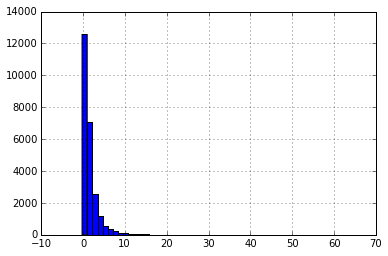

In [82]:
pd.concat((y_train, y_val), axis=0).hist(bins=50)

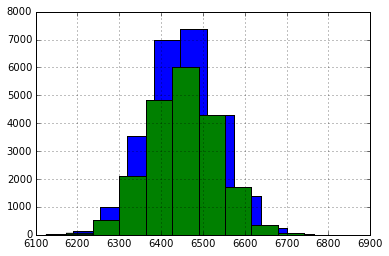

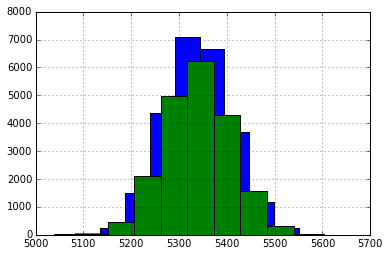

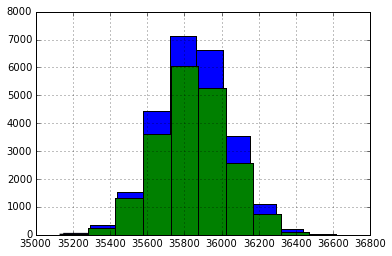

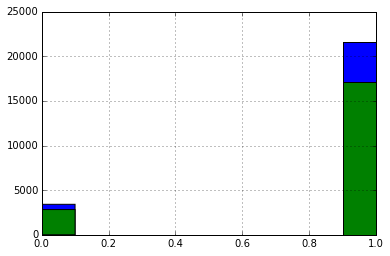

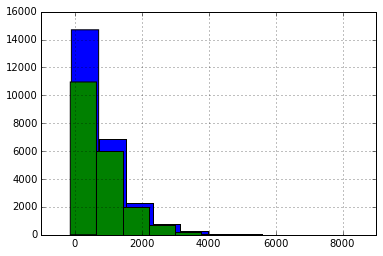

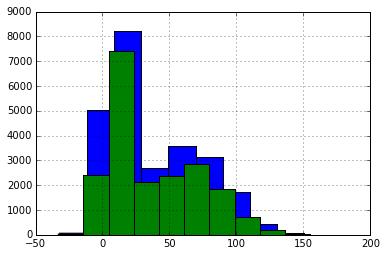

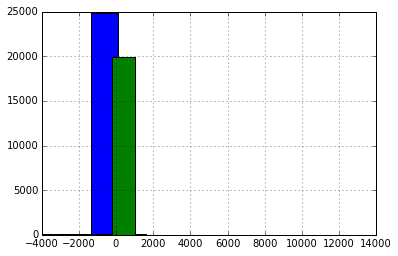

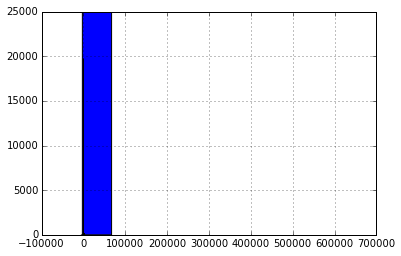

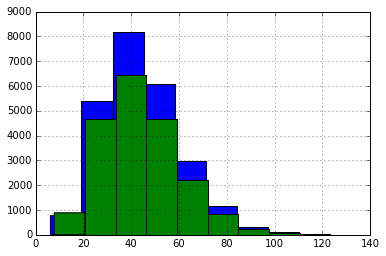

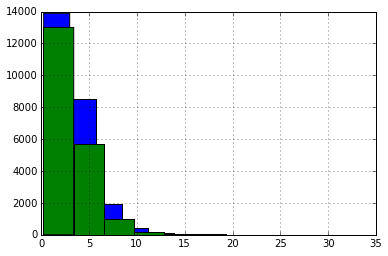

In [17]:
for col in X_train.columns[:10]:
    X_test[col].hist()
    X_train[col].hist()
    plt.show()

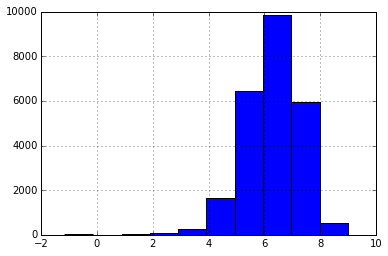

In [21]:
import numpy as np
X_test[X_train.columns[4]].apply(np.log).hist()


We will use three models:
    - a Linear Regression
    - a Random Forest regression
    - a Neural Network with stochastic gradient descent
    
We will not use any dimension reduction technique (PCA, autoencoders...) since the size of the dataset is still managable on a laptop.

### Dimension Reduction

In [86]:
pca = PCA(n_components=60)
pca.fit(X_train_scaled)
print(sum(pca.explained_variance_ratio_))

0.82378205138


In [87]:
X_train_scaled_reduced = pca.transform(X_train_scaled)
X_val_scaled_reduced = pca.transform(X_val_scaled)

### Linear Regression

Fit a linear regression on the data

In [88]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [89]:
lr_predictions_train_scaled = lr.predict(X_train_scaled)
lr_predictions_train = (lr_predictions_train_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_train, lr_predictions_train))
lr_predictions_val_scaled = lr.predict(X_val_scaled)
lr_predictions_val = (lr_predictions_val_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_val, lr_predictions_val))

3.460385934391223
5.520964520993325


In [133]:
from sklearn.linear_model import Ridge 

lr = Ridge(alpha=1000.0)
lr.fit(X_train_scaled, y_train_scaled)

lr_predictions_train_scaled = lr.predict(X_train_scaled)
lr_predictions_train = (lr_predictions_train_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_train, lr_predictions_train))
lr_predictions_val_scaled = lr.predict(X_val_scaled)
lr_predictions_val = (lr_predictions_val_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_val, lr_predictions_val))

2.276637315592737
3.685433346758918


In [131]:
from sklearn.linear_model import ElasticNet 

lr = ElasticNet(alpha=10.0, l1_ratio=0.75)
lr.fit(X_train_scaled, y_train_scaled)

lr_predictions_train_scaled = lr.predict(X_train_scaled)
lr_predictions_train = (lr_predictions_train_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_train, lr_predictions_train))
lr_predictions_val_scaled = lr.predict(X_val_scaled)
lr_predictions_val = (lr_predictions_val_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_val, lr_predictions_val))

4.9209896367578825
5.655911382571438


In [108]:
from sklearn.linear_model import Ridge 

lr = Ridge(alpha=100.)
lr.fit(X_train_scaled_reduced, y_train_scaled)

lr_predictions_train_scaled = lr.predict(X_train_scaled_reduced)
lr_predictions_train = (lr_predictions_train_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_train, lr_predictions_train))
lr_predictions_val_scaled = lr.predict(X_val_scaled_reduced)
lr_predictions_val = (lr_predictions_val_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_val, lr_predictions_val))

3.8520588965741034
4.474073829377753


### Random Forest regressor

In [110]:
score_train = []
score_val = []
max_depths = list(range(1, 11))
for max_depth_ in max_depths:
    rf = RandomForestRegressor(n_estimators=10, max_depth=max_depth_)
    rf.fit(X_train, y_train)
    score_train.append(MSE(y_train, rf.predict(X_train)))
    score_val.append(MSE(y_val, rf.predict(X_val)))

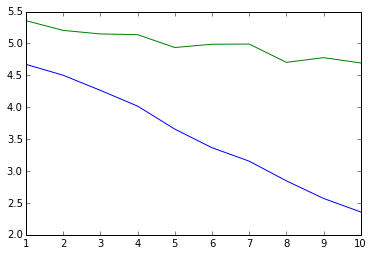

In [111]:
plt.plot(max_depths, score_train)
plt.plot(max_depths, score_val)

In [109]:
rf = RandomForestRegressor(n_estimators=10, max_depth=5)
rf.fit(X_train_reduced, y_train)
print(MSE(y_train, rf.predict(X_train_reduced)))
print(MSE(y_val, rf.predict(X_val_reduced)))

NameError: name 'X_train_reduced' is not defined

### Neural network

In [144]:
nn = Sequential()
"""
# without categorical variables: 3.9
nn.add(Dense(input_dim=X_train_scaled.shape[1], output_dim=1024, init='uniform', activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(input_dim=1024, output_dim=1024, init='uniform', activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(input_dim=1024, output_dim=1, init='uniform', activation='linear'))
"""

nn.add(Dense(input_dim=X_train_scaled.shape[1], output_dim=2048, init='uniform', activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(input_dim=2048, output_dim=2048, init='uniform', activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(input_dim=2048, output_dim=1, init='uniform', activation='linear'))

"""
nn.add(Dense(input_dim=99, output_dim=1, init='zero', activation='linear'))
"""

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0., nesterov=False)
nn.compile(loss='mean_squared_error', optimizer=sgd)

nn.fit(X_train_scaled.values, y_train_scaled.values, nb_epoch=2, batch_size=128)

Epoch 1/2
19980/19980 [==============================] - 43s - loss: 1.4440    
Epoch 2/2
19980/19980 [==============================] - 44s - loss: 1.3511    


In [141]:
objective_score = nn.evaluate(X_val_scaled.values, y_val_scaled.values, batch_size=128)
print(objective_score)

4996/4996 [==============================] - 1s     
0.989619544352


In [142]:
nn_predictions_scaled = nn.predict(X_val_scaled.values)
nn_predictions = (nn_predictions_scaled * y_train_std + y_train_mean).ravel()
print(MSE(y_val, nn_predictions))

5.015582707158902


In [49]:
predictions

array([[ 1.1848242 ],
       [-0.01878066],
       [ 1.58171142],
       ..., 
       [ 1.95762783],
       [ 2.76860658],
       [ 1.68961748]])